**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [550]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import kd_tree
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Корректное отображение графиков прямо в jupyter'e
%matplotlib inline
#Все функции matplotlib API, в частности plot и close, находятся в модуле matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [626]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, distance='euclidean', algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.distance_metric = distance
    
    def distance(self, X):
        if self.distance_metric == 'euclidean':
            dist = scipy.spatial.distance_matrix(X, self.X_train)
            return dist
            #dist = DistanceMetric.get_metric('euclidean')
            #return dist.pairwise(X, self.X_train)
            
        elif self.distance_metric == 'cosine':
            return cosine_similarity(X, self.X_train) * (-1)
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X_train = X
        elif self.algorithm == 'kd_tree':
            self.tree = kd_tree.KDTree(X, 2 * self.n_neighbors)
        self.y_train = y
    
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = self.distance(X)
            indices =  np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            return scipy.stats.mode(self.y_train[indices], axis=1)[0].flatten()
        elif self.algorithm == 'kd_tree':
            indices = self.tree.query(X_test, k=self.n_neighbors)[1]
            labels = self.y_train[indices]
            return scipy.stats.mode(labels, axis=1)[0].flatten()

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [552]:
iris = datasets.load_iris()

In [553]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [554]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [555]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [556]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [557]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [558]:
accuracy_score(my_clf_pred, y_test)

1.0

In [559]:
# вариант с нормализацией
clf = MyKNeighborsClassifier(n_neighbors=2)
clf.fit(X_train_norm, y_train)
predict = clf.predict(X_test_norm)
accuracy = accuracy_score(predict, y_test)
print(accuracy)

0.9333333333333333


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [627]:
%time clf.fit(X_train, y_train)

CPU times: user 343 µs, sys: 103 µs, total: 446 µs
Wall time: 418 µs


In [628]:
%time my_clf.fit(X_train, y_train)

CPU times: user 382 µs, sys: 124 µs, total: 506 µs
Wall time: 423 µs


In [629]:
%time clf.predict(X_test)

CPU times: user 1.45 ms, sys: 339 µs, total: 1.79 ms
Wall time: 1.61 ms


array([0, 0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2])

In [630]:
%time my_clf.predict(X_test)

CPU times: user 1.22 ms, sys: 12 µs, total: 1.23 ms
Wall time: 1.24 ms


array([0, 0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [631]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [632]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [633]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [634]:
my_clf.fit(X_train, y_train)

In [635]:
%time clf.fit(X_train, y_train)

CPU times: user 802 µs, sys: 135 µs, total: 937 µs
Wall time: 902 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [636]:
%time my_clf.fit(X_train, y_train)

CPU times: user 245 µs, sys: 78 µs, total: 323 µs
Wall time: 381 µs


In [637]:
%time clf.predict(X_test)

CPU times: user 2.14 ms, sys: 603 µs, total: 2.75 ms
Wall time: 2.34 ms


array([0, 1, 2, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0])

In [638]:
%time my_clf.predict(X_test)

CPU times: user 1.55 ms, sys: 519 µs, total: 2.07 ms
Wall time: 1.62 ms


array([0, 1, 2, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0])

In [639]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [640]:
accuracy_score(my_clf_pred, y_test)

1.0

In [641]:
# вариант с нормализацией
clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
clf.fit(X_train_norm, y_train)
predict = clf.predict(X_test_norm)
accuracy = accuracy_score(predict, y_test)
print(accuracy)

1.0


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [575]:
# Здесь функция для расстояния взята из sklearn

class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, distance='euclidean', algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.distance_metric = distance
    
    def distance(self, X):
        if self.distance_metric == 'euclidean':
            dist = DistanceMetric.get_metric('euclidean')
            return dist.pairwise(X, self.X_train)
        elif self.distance_metric == 'cosine':
            return cosine_similarity(X, self.X_train) * (-1)
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X_train = X
        elif self.algorithm == 'kd_tree':
            self.tree = kd_tree.KDTree(X, 1)
        self.y_train = y
    
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = self.distance(X)
            indices =  np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            return scipy.stats.mode(self.y_train[indices], axis=1)[0].flatten()
        elif self.algorithm == 'kd_tree':
            indices = self.tree.query(X_test, k=self.n_neighbors)[1]
            labels = self.y_train[indices]
            return scipy.stats.mode(labels, axis=1)[0].flatten()

In [642]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [643]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [644]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [579]:
vectorizer = CountVectorizer(max_features=1000)
tfidf = TfidfVectorizer(max_features=1000)
data_m = vectorizer.fit_transform(data).todense()
data_tfidf = tfidf.fit_transform(data).todense()

In [580]:
data_m_norm = normalize(data_m)
data_tfidf_norm = normalize(data_tfidf)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [581]:
def cross_validation(model, data, target, n_splits=3):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    results = []
    for train_ids, val_ids in kfold.split(data_m):
        clf.fit(data[train_ids], target[train_ids])
        results.append(accuracy_score(target[val_ids], clf.predict(data[val_ids])))
    return np.mean(np.array(results))

In [582]:
clf = MyKNeighborsClassifier(n_neighbors=5)
accuracy = cross_validation(clf, data_m, target)
print(accuracy)

0.18242810216833102


In [583]:
# вариант с нормализацией
clf = MyKNeighborsClassifier(n_neighbors=5)
accuracy = cross_validation(clf, data_m_norm, target)
print(accuracy)

0.2169873686734515


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [584]:
def opt_parameter(data, target, n_range, cv=3, distance='euclidean'):
    results = []
    for n in tqdm(n_range, total=len(n_range)):
        clf = MyKNeighborsClassifier(n_neighbors=n, distance=distance)
        accuracy = cross_validation(clf, data, target, n_splits=cv)
        results.append((n, accuracy))
    return results

In [585]:
results = opt_parameter(data_m, target, range(1, 11))

100%|██████████| 10/10 [18:02<00:00, 108.20s/it]


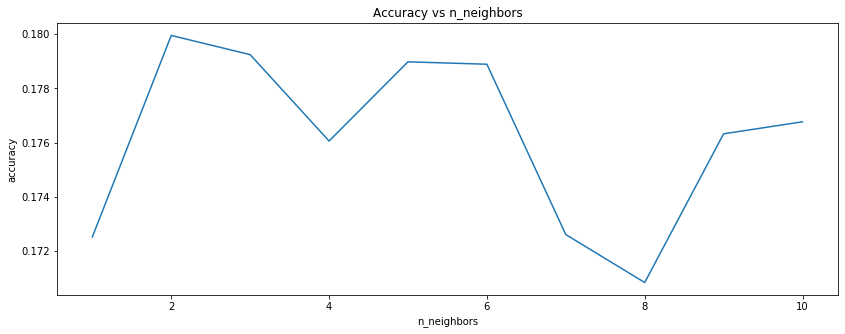

In [586]:
def results_plot(results):
    fig = plt.figure(figsize=(14,5))
    ax = plt.subplot(111)

    x_data = [x[0] for x in results]
    y_data = [x[1] for x in results]

    ax.plot(x_data, y_data)

    ax.set_xlabel("n_neighbors")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs n_neighbors")
    
results_plot(results)

In [587]:
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

Optimal n_neighbors: 2
Accuracy: 0.1799539639407324


100%|██████████| 10/10 [18:13<00:00, 109.39s/it]


Optimal n_neighbors: 3
Accuracy: 0.22290959480450187


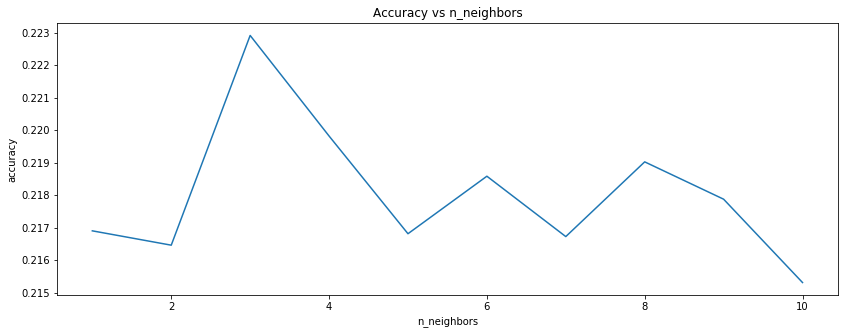

In [588]:
# вариант с нормализацией
results = opt_parameter(data_m_norm, target, range(1, 11))
results_plot(results)
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [600]:
clf = MyKNeighborsClassifier(2, distance='cosine')
accuracy = cross_validation(clf, data_m, target)
print("Accuracy with cosine similatiry:", accuracy)

Accuracy with cosine similatiry: 0.24005714106810747


In [601]:
clf = MyKNeighborsClassifier(2)
accuracy = cross_validation(clf, data_tfidf, target)
print("Accuracy with tfidf:", accuracy)

Accuracy with tfidf: 0.2129221639834952


In [613]:
# вариант с нормализацией
clf = MyKNeighborsClassifier(3)
accuracy = cross_validation(clf, data_tfidf_norm, target)
print("Accuracy with tfidf:", accuracy)

Accuracy with tfidf: 0.22237880968965684


In [603]:
clf = MyKNeighborsClassifier(2, distance='cosine')
accuracy = cross_validation(clf, data_tfidf, target)
print("Accuracy with tfidf:", accuracy)

Accuracy with tfidf: 0.3868657656864694


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization for cosine and countVect


100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Optimal n_neighbors: 10
Accuracy: 0.2509275499174693


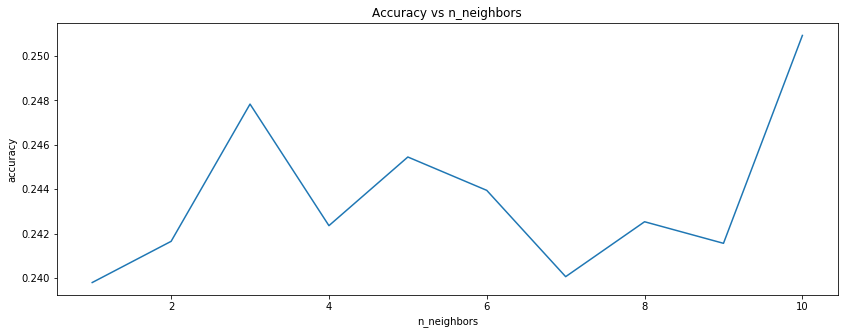

In [593]:
print("Optimization for cosine and countVect")
results = opt_parameter(data_m, target, range(1, 11), distance='cosine')
results_plot(results)
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization for euclidean and tfidfVect


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Optimal n_neighbors: 3
Accuracy: 0.24792262657502573


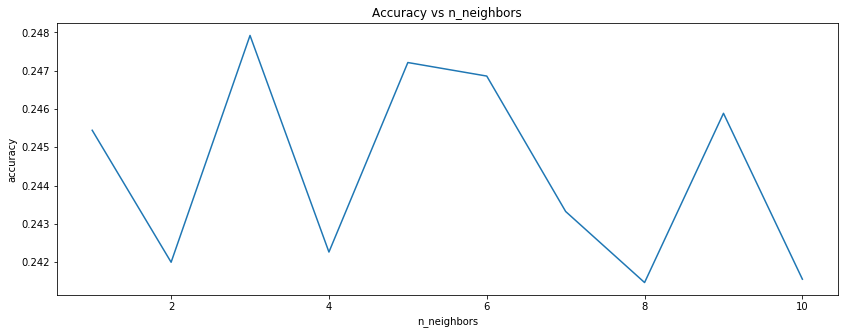

In [594]:
print("Optimization for euclidean and tfidfVect")
results = opt_parameter(data_m, target, range(1, 11))
results_plot(results)
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization for euclidean and tfidfVect


100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


Optimal n_neighbors: 6
Accuracy: 0.24695127809774867


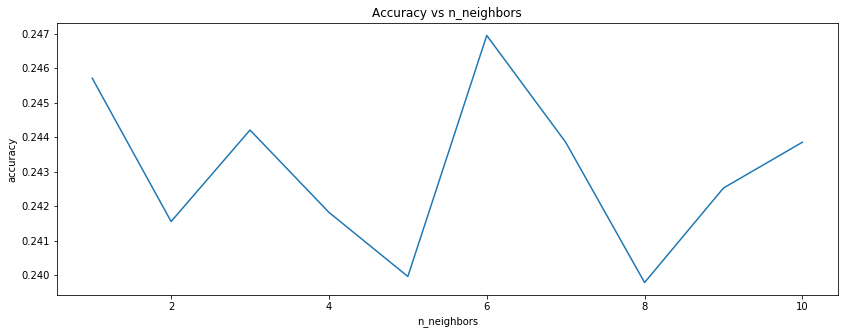

In [595]:
# вариант с нормализацией
print("Optimization for euclidean and tfidfVect")
results = opt_parameter(data_m_norm, target, range(1, 11))
results_plot(results)
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization for cosine and tfidfVect


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Optimal n_neighbors: 9
Accuracy: 0.40984681611888235


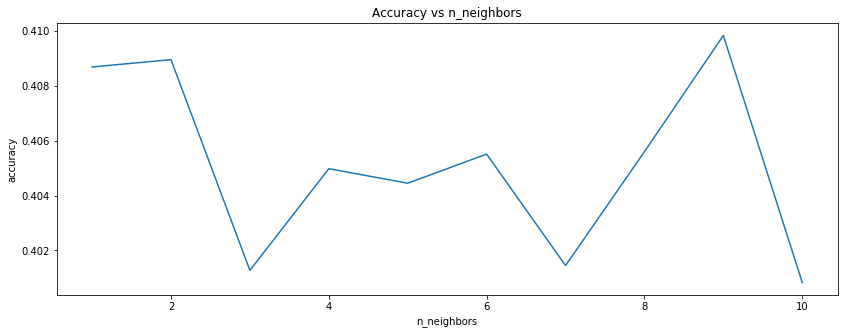

In [609]:
print("Optimization for cosine and tfidfVect")
results = opt_parameter(data_tfidf, target, range(1, 11), distance='cosine')
results_plot(results)
n_opt = max(results, key=lambda x: x[1])
print("Optimal n_neighbors:", n_opt[0])
print("Accuracy:", n_opt[1])

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [610]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']
data_test_tfidf = tfidf.transform(data_test).todense()

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [611]:
clf = MyKNeighborsClassifier(n_neighbors=9, distance='cosine')
clf.fit(data_tfidf, target)
accuracy_test = accuracy_score(target_test, clf.predict(data_test_tfidf))
print(accuracy_test)

0.37254381306425915


Качество на тесте меньше, чем на кросс-валидации. Можно предположить, что это связано с большим количеством признаков. Кроме того, в тестовом датасете могли встретиться слова, которых не было в обучающей выборке:

In [612]:
vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(data)
words1 = vectorizer.vocabulary_.keys()
words1 = set(words1)
vectorizer.fit(data_test)
words2 = vectorizer.vocabulary_.keys()
words2 = set(words2)
print("IoU для словарей в test и train:", len(words2 & words1) / (len(words1 | words2)))

IoU для словарей в test и train: 0.7985611510791367
